In [4]:
import pandas as pd

"""テキストをリストにまとめる"""

#negative or positive
labels = []
#text data
texts = []


imdb = pd.read_csv('imdb.csv')
for item in imdb[1:].itertuples():
    texts.append(item[1])
    if item[2] == 'negative':
        labels.append(0)
    else:
        labels.append(1)

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

"""データのトークン化"""

max_len = 100 #単語長の取得限界
training_samples = 200 #訓練データ
validation_samples = 10000 #検証データ
max_words = 10000 #データセットの最初から10,000ワードのみを考慮

#インスタンス生成
tokenizer = Tokenizer(num_words=max_words)
#単語に連番振ってベクトル化(dict)
tokenizer.fit_on_texts(texts)
#単語に連番振ってベクトル化(ベクトルだけのlist)
sequences = tokenizer.texts_to_sequences(texts)

#見つかった単語の種類
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

#固定長変換
data = pad_sequences(sequences, maxlen=max_len)

#labelsをnumpy配列に変換
labels = np.asarray(labels)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

#データを訓練データと検証データに分割
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 124252 unique tokens.
Shape of data tensor: (49999, 100)
Shape of label tensor: (49999,)


In [7]:
"""GloVeによる学習済みデータの読み込み"""

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf-8")
for line in f:
    #単語毎に区切る
    values = line.split()
    #index:0--単語, index:1--単語ベクトル
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    #dictに登録
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [9]:

"""GloVeの埋め込み行列の作成"""

embedding_dim = 100
#単語埋め込み行列
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    #GloVeから学習データの単語のベクトルを抽出(なけらばNone)
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [10]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

"""モデル構築"""

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [11]:

"""Embedding_layerに学習済みの重みパラメータを流す"""

#学習済みモデルの重みを反映
model.layers[0].set_weights([embedding_matrix])
#Embedding_layerの重みを凍結
model.layers[0].trainable = False

In [12]:

"""モデルのコンパイル, 学習"""

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(x_val, y_val))

#重みの保存
model.save_weights('pre_trained_glove_model.h5')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 7ms/step - loss: 1.8269 - acc: 0.5100 - val_loss: 0.6921 - val_acc: 0.5129
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.9116 - acc: 0.5200 - val_loss: 0.6925 - val_acc: 0.5186
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.5463 - acc: 0.7600 - val_loss: 1.0873 - val_acc: 0.4990
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.5186 - acc: 0.7750 - val_loss: 1.1823 - val_acc: 0.4984
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.4554 - acc: 0.7400 - val_loss: 0.7052 - val_acc: 0.5356
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.2570 - acc: 0.9000 - val_loss: 1.7924 - val_acc: 0.5034
Epoch 7/10
200/200 [==============================] - 0s 2ms/step

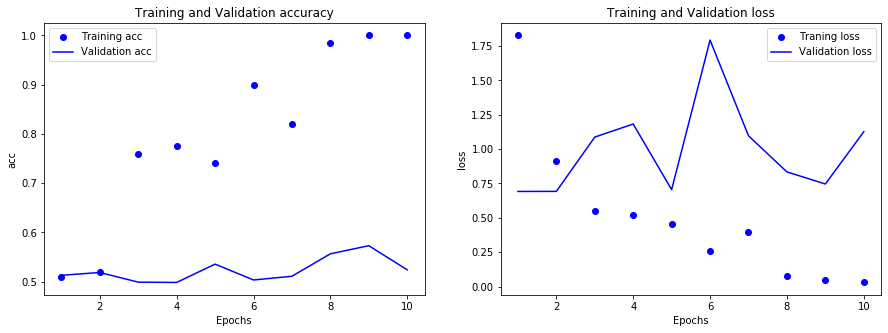

In [14]:
import matplotlib.pyplot as plt

"""可視化"""

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()

fig.add_subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Traning loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.savefig('glove.png')
plt.show()

In [ ]:

"""テストデータで評価"""
#test_dir = os.path